In [1]:
#### various import statements

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path, PureWindowsPath
import custom_functions as cf
import cv2
import pandas as pd

%matplotlib inline

In [2]:
###specify the output file to write the extracted features to

OUTPUT_FILE_NAME = "log.csv"

In [3]:
#### FILES are in proprietary file format from the microscope instrument maker
#### we must be convert to numpy arrays

FILE_PATH = ""
FILE_NAME = 'Experiment_0032.nd2'
STR_PATH = FILE_PATH + "" + FILE_NAME 

FULL_ND2_ARRAY, FR = cf.ND2asNP(STR_PATH)

x 512
y 512
t 999


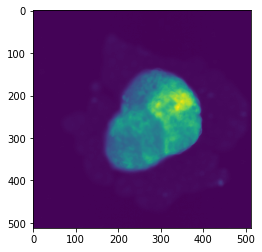

In [4]:
#### a temporally averaged intensity plot gives a decent idea of the brightest pixels
#### these can be selected as a region of interest 

SPATIAL_AVG = np.average(FULL_ND2_ARRAY,2)
NORM_SPATIAL_AVG = cf.norm_input(SPATIAL_AVG)
plt.imshow(NORM_SPATIAL_AVG)

<IPython.core.display.Javascript object>


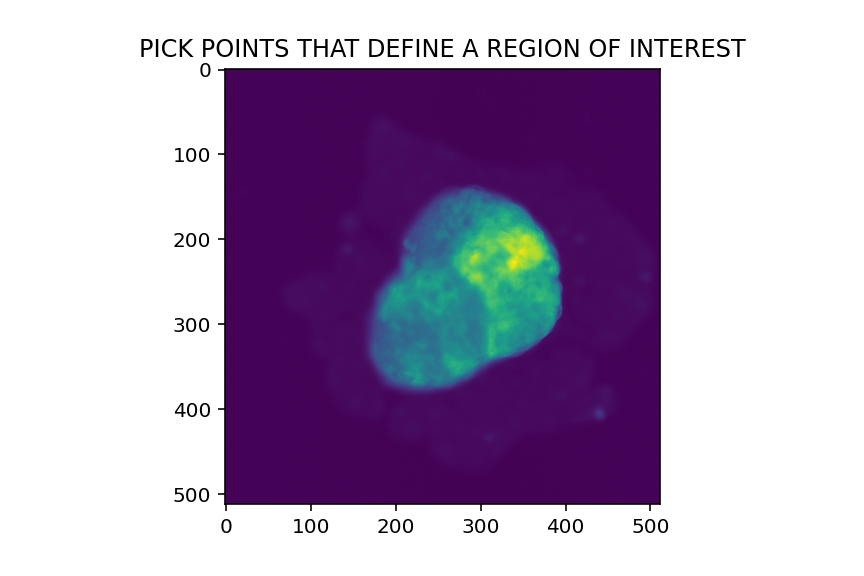

In [5]:
#### lets the user click on a matplotlib graph to select endpoints of a region of interest

%matplotlib notebook

def two_clicks(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))

    global coords
    coords.append((ix, iy))

    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords



ax = plt.gca()
fig = plt.gcf()
plt.title('PICK POINTS THAT DEFINE A REGION OF INTEREST')
implot = ax.imshow(NORM_SPATIAL_AVG)

coords = []

cid = implot.figure.canvas.mpl_connect('button_press_event', two_clicks)
#cid = fig.canvas.mpl_connect('button_press_event', onclick)

[(105.44113318616627, 116.2093451066961), (380.93782192788814, 349.321927888153)]


Text(0.5, 1.0, 'THIS IS YOUR SELECTED ROI')

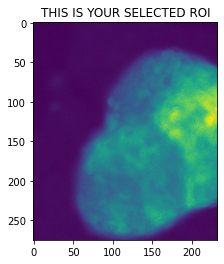

In [6]:
#### plots the selected region while also supporting whole-well averaging for "lazy"-mode analysis. 

print(coords)
%matplotlib notebook
%matplotlib inline

SNIPPED_ARRAY = cf.get_snipped_array(coords,FULL_ND2_ARRAY)
plt.imshow(SNIPPED_ARRAY[:,:,10])
plt.title("THIS IS YOUR SELECTED ROI")

Text(0.5, 1.0, 'THIS IS THE TIME SERIES OF YOUR SELECTED TRACE')

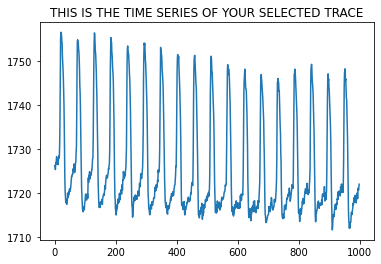

In [7]:
ROI_TRACE = np.average(np.average(SNIPPED_ARRAY,0),0)
plt.plot(ROI_TRACE)
plt.title("THIS IS THE TIME SERIES OF YOUR SELECTED TRACE")

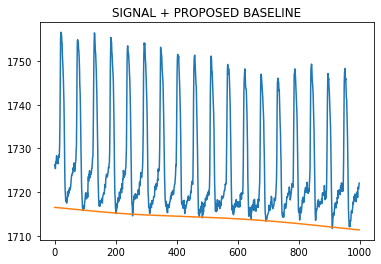

In [8]:
#### allows for baseline subtraction while also supporting tuning for more or less noisey data 
BASELINE = cf.baseline_als(y=ROI_TRACE, lam = 1000000, p = 0.0001)

plt.plot(ROI_TRACE)
plt.plot(BASELINE)
plt.title("SIGNAL + PROPOSED BASELINE")
plt.show()

Text(0.5, 1.0, 'BASELINE SUBRTRACTED SIGNAL')

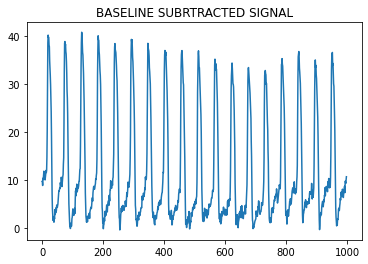

In [9]:
#### replotting corrected signal
BASELINE_CORRECTED_ROI = ROI_TRACE - BASELINE
plt.plot(BASELINE_CORRECTED_ROI)
plt.title("BASELINE SUBRTRACTED SIGNAL")

In [10]:
#### allows user to specify expected peaks and trough distances based on above plots. 
from scipy.signal import find_peaks
peaks, _= find_peaks(BASELINE_CORRECTED_ROI, distance = 50)
troughs, _= find_peaks(-BASELINE_CORRECTED_ROI, distance = 40)

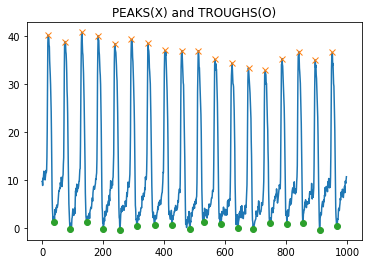

In [15]:
#### these two cells can be run repeatedly to arrive at an optimized automatic peak and trough selection
%matplotlib inline
plt.plot(BASELINE_CORRECTED_ROI)
plt.plot(peaks, BASELINE_CORRECTED_ROI[peaks], "x")
plt.plot(troughs, BASELINE_CORRECTED_ROI[troughs], "o")
plt.title("PEAKS(X) and TROUGHS(O)")
plt.show()

In [16]:
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))

    global coords
    coords.append((ix, iy))

    return coords

In [17]:
#### these next blocks allow a user to adjust the automated peak and trough selection as needed

str_choice = 'peaks' #can pick peaks or troughs

temp_pts = cf.get_pts_to_change(str_choice,peaks,troughs)


In [18]:
#### what change do you want to apply? options are add, drop, replace (repl)

change = cf.get_change('add')

<IPython.core.display.Javascript object>


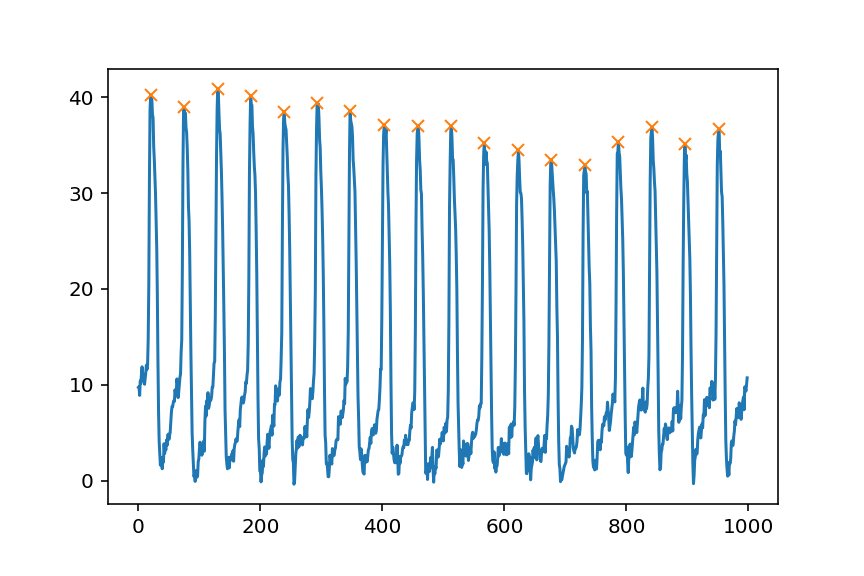

In [19]:
#### click on the graph to make your selections

%matplotlib notebook

ax = plt.gca()
fig = plt.gcf()
implot = ax.plot(BASELINE_CORRECTED_ROI)
implot = ax.plot(temp_pts, BASELINE_CORRECTED_ROI[temp_pts],"x")

coords = []

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [20]:
print(coords)
temp_pts = change(temp_pts, coords)

[(985.1794037485067, 8.338377774712608), (988.4583762694147, 9.381104060387916)]


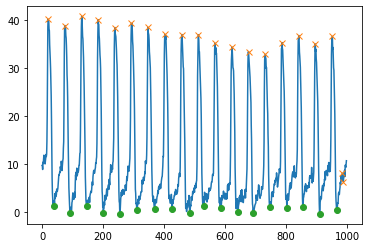

In [21]:
### this is what your selection looks like, are u happy with it? 
%matplotlib inline
if str_choice == "peaks":
    plt.plot(BASELINE_CORRECTED_ROI)
    plt.plot(temp_pts,BASELINE_CORRECTED_ROI[temp_pts],"x")
    plt.plot(troughs, BASELINE_CORRECTED_ROI[troughs], "o")
    plt.show()
if str_choice == "troughs":
    plt.plot(BASELINE_CORRECTED_ROI)
    plt.plot(peaks,BASELINE_CORRECTED_ROI[peaks],"x")
    plt.plot(temp_pts, BASELINE_CORRECTED_ROI[temp_pts], "o")
    plt.show()
    

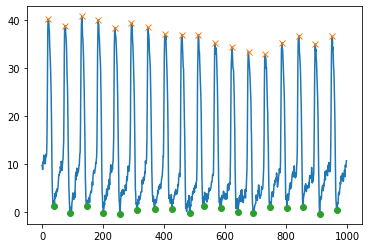

In [22]:
#### original signal for comparison 

plt.plot(BASELINE_CORRECTED_ROI)
plt.plot(peaks, BASELINE_CORRECTED_ROI[peaks], "x")
plt.plot(troughs, BASELINE_CORRECTED_ROI[troughs], "o")
plt.show()

In [23]:
#### saves the new selection and writes over original
#### to get original back rerun the 11th cell
#### you can go back and rerun with different settings. ex. add peaks, then replace troughs, then drop peaks, etc. 

if str_choice == "troughs":
    troughs = temp_pts
if str_choice == "peaks":
    peaks = temp_pts
else:
    'Please update string choice to either peaks or troughs and follow accordingly.'

In [24]:
#### returns a summary matrix that splits trace into groups of peaks and troughs
#### extracts basic info like, peak position, trough positions, distances between points, phase offset b/w traces

ap_lengths = cf.get_summary_matrix(peaks,troughs)

In [25]:
ap_lengths

array([[ 39.,  93.,  75.,  36.,  18.,   6.],
       [ 93., 146., 130.,  37.,  16.,   5.],
       [146., 201., 184.,  38.,  17.,   4.],
       [201., 255., 239.,  38.,  16.,   4.],
       [255., 311., 293.,  38.,  18.,   4.],
       [311., 370., 347.,  36.,  23.,   6.],
       [370., 426., 403.,  33.,  23.,   9.],
       [426., 484., 459.,  33.,  25.,   9.],
       [484., 530., 513.,  29.,  17.,  13.],
       [530., 586., 567.,  37.,  19.,   5.],
       [586., 643., 623.,  37.,  20.,   5.],
       [643., 692., 677.,  34.,  15.,   8.],
       [692., 748., 732.,  40.,  16.,   2.],
       [748., 803., 787.,  39.,  16.,   3.],
       [803., 855., 842.,  39.,  13.,   3.],
       [855., 910., 896.,  41.,  14.,   1.],
       [910., 966., 952.,  42.,  14.,   0.]])

In [26]:
#### uses summary table and signal to align traces and store in a matrix

holder_of_aligned = cf.get_aligned_matrix(ap_lengths, BASELINE_CORRECTED_ROI)

In [27]:
holder_of_aligned.shape

(17, 67)

Text(0.5, 1.0, 'ALIGNED APs')

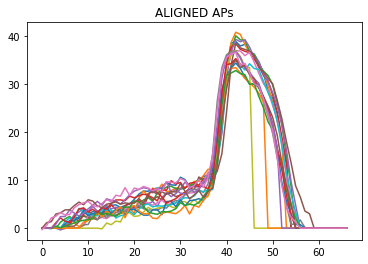

In [28]:
#### plots aligned, un-normalized traces 

for i in range(ap_lengths.shape[0]):
    plt.plot(holder_of_aligned[i,:])
plt.title("ALIGNED APs")

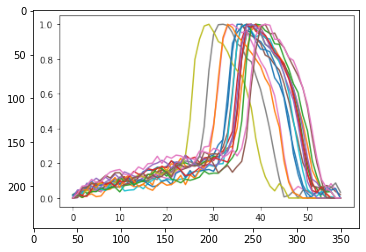

In [42]:
#### for reference, this is what signals would look like without phase correction
#### analysis applied to an averaged trace from this would not be very meaningful
import matplotlib.image as img
unaligned = img.imread('unaligned.png')
plt.imshow(unaligned)

In [30]:
NORM_ALIGNED = np.zeros(holder_of_aligned.shape)

for i in range(holder_of_aligned.shape[0]):
    NORM_ALIGNED[i] = cf.ap_norm(holder_of_aligned[i])

Text(0.5, 1.0, 'NORMALIZED, ALIGNED APs')

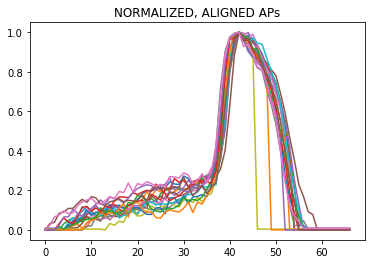

In [31]:
#### same as previous, but now normalized on each trace to accoutn for photobleaching

for i in range(holder_of_aligned.shape[0]):
    plt.plot(NORM_ALIGNED[i])
plt.title("NORMALIZED, ALIGNED APs")

In [32]:
AVG_TRACE = np.average(NORM_ALIGNED,0)

Text(0.5, 1.0, 'NORMALIZED AVERAGED TRACE')

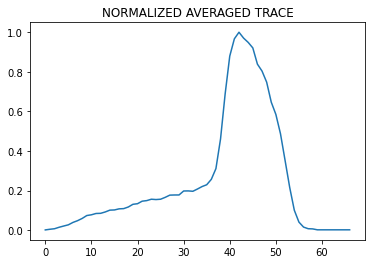

In [33]:
plt.plot(AVG_TRACE)
plt.title("NORMALIZED AVERAGED TRACE")

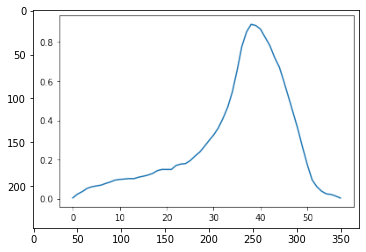

In [43]:
### unaligned average for reference 
unaligned_avg = img.imread('unaligned_avg.png')
plt.imshow(unaligned_avg)

In [34]:
#### extracts features to describe data

func_current_APD, func_c_length, func_t_to_peak, func_t_post_peak, func_peak_to_peak = cf.get_features(
    AVG_TRACE, NORM_ALIGNED, ap_lengths, FR)

In [35]:
    column_names = ["FILENAME","length","num_aps","beatrate",
                    "APD20","APD30","APD40","APD50","APD60","APD70","APD80","APD90",
                    "c_length_mean", "c_length_var",
                    "t_to_peak_mean", "t_to_peak_var",
                    "t_post_peak_mean", "t_post_peak_var",
                    "peak_to_peak_mean", "peak_to_peak_var"
                   ]

In [36]:
TEST = {'filename':FILE_NAME,
        'length': BASELINE_CORRECTED_ROI.shape[0]*1/FR,
        'num_aps': ap_lengths.shape[0],
        'beatrate': ap_lengths.shape[0]/(BASELINE_CORRECTED_ROI.shape[0]*1/FR),
        "APD20": func_current_APD[0],
        "APD30": func_current_APD[1],
        "APD40": func_current_APD[2],
        "APD50": func_current_APD[3],
        "APD60": func_current_APD[4],
        "APD70": func_current_APD[5],
        "APD80": func_current_APD[6],
        "APD90": func_current_APD[7],
        "c_length_mean": cf.get_mean_var(func_c_length)[0]*1/FR,
        "c_length_var": cf.get_mean_var(func_c_length)[1]*1/FR,
        "t_to_peak_mean": cf.get_mean_var(func_t_to_peak)[0]*1/FR, 
        "t_to_peak_var": cf.get_mean_var(func_t_to_peak)[1]*1/FR,
        "t_post_peak_mean": cf.get_mean_var(func_t_post_peak)[0]*1/FR, 
        "t_post_peak_var": cf.get_mean_var(func_t_post_peak)[1]*1/FR,
        "peak_to_peak_mean": cf.get_mean_var(func_peak_to_peak)[0]*1/FR, 
        "peak_to_peak_var": cf.get_mean_var(func_peak_to_peak)[1]*1/FR
       }

In [37]:
for key, value in TEST.items():
    print(key, value)

filename Experiment_0032.nd2
length 10.646528400000184
num_aps 17
beatrate 1.5967646317460353
APD20 0.09591467027027192
APD30 0.1065718558558577
APD40 0.11722904144144346
APD50 0.12788622702702923
APD60 0.138543412612615
APD70 0.14920059819820078
APD80 0.15985778378378654
APD90 0.1705149693693723
c_length_mean 0.5811300610492947
c_length_var 0.10170421399669742
t_to_peak_mean 0.3930620801271928
t_to_peak_var 0.1051705650176146
t_post_peak_mean 0.18806798092210184
t_post_peak_var 0.1165283960223219
peak_to_peak_mean 0.58414698490992
peak_to_peak_var 0.006952148409346967


In [38]:
df = pd.DataFrame(TEST,index=["i"])

In [39]:
df

,filename,length,num_aps,beatrate,APD20,APD30,APD40,APD50,APD60,APD70,APD80,APD90,c_length_mean,c_length_var,t_to_peak_mean,t_to_peak_var,t_post_peak_mean,t_post_peak_var,peak_to_peak_mean,peak_to_peak_var
i,Experiment_0032.nd2,10.646528,17,1.596765,0.095915,0.106572,0.117229,0.127886,0.138543,0.149201,0.159858,0.170515,0.58113,0.101704,0.393062,0.105171,0.188068,0.116528,0.584147,0.006952


In [40]:
#### makes a new log if one by the name specified above doesn't exist
#### if one exists, appends this row of data
#### this CSV could be opened externally and analyzed in Excel, or whatever the user is most comfortable with. 

cf.write_to_output(df,OUTPUT_FILE_NAME)

EXISTING FILE, WRITING THIS ROW
